In [3]:
import sys
import xarray as xr
import numpy as np
import pandas as pd
import math
import glob
import yaml
import cartopy
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
import matplotlib.ticker as mticker
import cmocean.cm as cmo
import seaborn as sns

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature
import dask

# import personal modules
# Path to modules
sys.path.append('../modules')
# Import my modules
from utils import roundPartial, select_months_ds
from plotter import draw_basemap, plot_terrain, plot_arscale_cbar
from colorline import colorline
from trajectory_post_funcs import calculate_heatmaps_from_trajectories
import customcmaps as ccmaps
import contribution as contr

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [4]:
server='expanse'
if server == 'comet':
    path_to_data = '/data/projects/Comet/cwp140/'
elif server == 'expanse':
    path_to_data = '/expanse/nfs/cw3e/cwp140/'
elif server == 'skyriver':
    path_to_data = '/home/dnash/comet_data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [5]:
## load PRISM and add WY coordinate
fname = path_to_data + 'preprocessed/PRISM/PRISM_HUC8_CO_sp.nc'
PRISM = xr.open_dataset(fname)
water_year = (PRISM.date.dt.month >= 10) + PRISM.date.dt.year
PRISM.coords['water_year'] = water_year
PRISM['prec'] = PRISM['prec']  / 25.4 # convert from mm to inches

## use AR Scale as criteria for identifying AR at coast
varname = 'ar_scale'
thres = 0

# ## use Rutz AR dt for identifying AR at coast
# varname = 'ar'
# thres = 0

# ## use tARgetv4 AR dt for identifying AR at coast
# varname = 'tARget'
# thres = 0

In [6]:
# HUC8ID = '14050001'
# HUC8_lbl = 'Upper Yampa'
# subbasin = 'Upper_Yampa'

# HUC8ID = '14080101'
# HUC8_lbl = 'Upper San Juan'
# subbasin = 'Upper_San_Juan'

HUC8ID = '14010001'
HUC8_lbl = 'Colorado Headwaters'
subbasin = 'Colorado_Headwaters'

HUC8ID = '14020001'
HUC8_lbl = 'East-Taylor'
subbasin = 'East_Taylor'

# path_to_data = '/expanse/nfs/cw3e/cwp140/preprocessed/UCRB_trajectories/combined/'
path_to_data = '/expanse/nfs/cw3e/cwp140/preprocessed/ERA5_trajectories/combined_all/'
df = contr.calculate_WY_contribution_total(path_to_data, PRISM, HUC8ID, varname, thres)
df2 = contr.calculate_WY_contribution(path_to_data, PRISM, HUC8ID, varname, thres)

In [7]:
df

,HUC8,Total Precipitation,AR Associated,Percent
water_year,,,,
2000,14020001,24.873496,9.516292,38.258762
2001,14020001,28.571500,3.787030,13.254573
2002,14020001,21.283943,3.862331,18.146688
2003,14020001,29.668661,9.135238,30.790868
2004,14020001,26.564822,7.988231,30.070711
2005,14020001,32.309230,11.607333,35.925750
2006,14020001,32.359995,11.351998,35.080347
2007,14020001,28.638343,8.423239,29.412454
2008,14020001,35.544601,14.593070,41.055660


/scratch/dnash/job_34287091/ipykernel_110516/2644815357.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  d1.set_xticklabels(d1.get_xticklabels(), rotation=45)


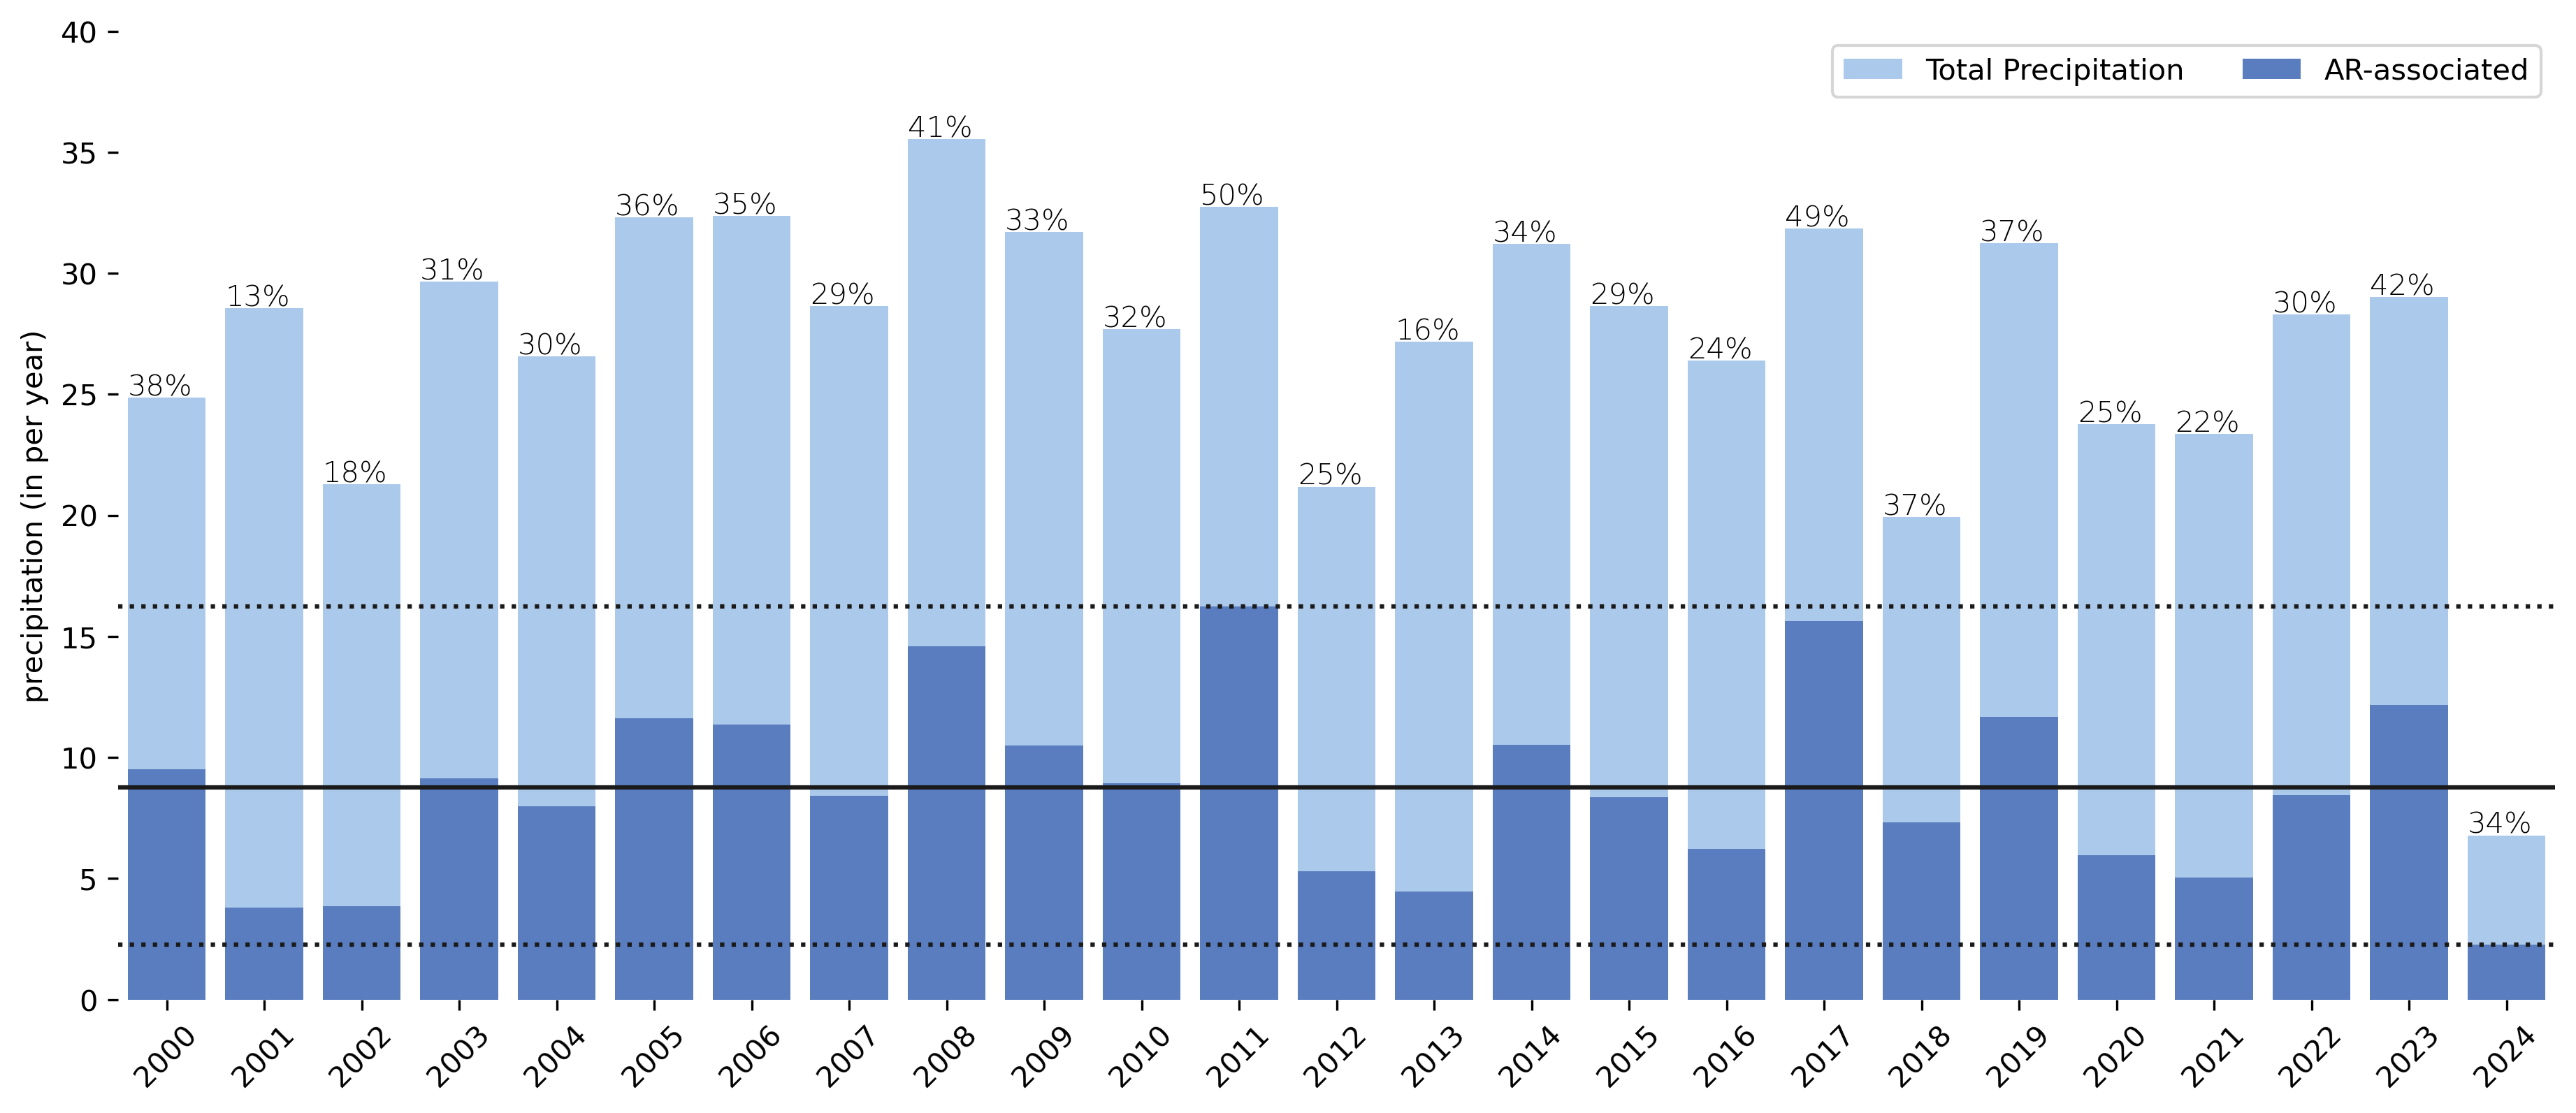

In [8]:
fig = plt.figure(figsize=(15,6))
fig.dpi = 300
fname = '../figs/time_series_{0}'.format(subbasin)
fmt1 = 'png'
gs = fig.add_gridspec(nrows=1, ncols=1)
color_list = ['b', 'r', 'g']


## Initialize the matplotlib figure
ax = fig.add_subplot(gs[0, 0])

# Plot the total precip
sns.set_color_codes("pastel")
d1 = sns.barplot(x=df.index, y="Total Precipitation", data=df, color='b', label="Total Precipitation")

# Plot the precipitation where ARs were involved
sns.set_color_codes("muted")
d2 = sns.barplot(x=df.index, y="AR Associated", data=df, color='b', label="AR-associated")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylim=(0, 40), ylabel="precipitation (in per year)", xlabel="")
sns.despine(left=True, bottom=True)
#     ax.set_title(subtitles[i])
d1.set_xticklabels(d1.get_xticklabels(), rotation=45)

## add min/max/mean/median lines
ax.axhline(y=df['AR Associated'].min(), color='k', linestyle=':')
ax.axhline(y=df['AR Associated'].max(), color='k', linestyle=':') 
ax.axhline(y=df['AR Associated'].mean(), color='k', linestyle='-')

yloc = df['Total Precipitation'].values
xloc = np.arange(0, len(df), 1)
proportion = df['Percent'].values
for i, (x, prop) in enumerate(zip(xloc, proportion)):
    if prop > 0:
        plt.text(x=x-0.4,
                 y=yloc[i]+0.1,
                 s=f'{int(np.round(prop, 0))}%',
                 color="black",
                 fontsize=10,
                 fontweight="light", zorder=200)
    
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
plt.show()

/scratch/dnash/job_34287091/ipykernel_110516/1278179045.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  d1.set_xticklabels(d1.get_xticklabels(), rotation=45)


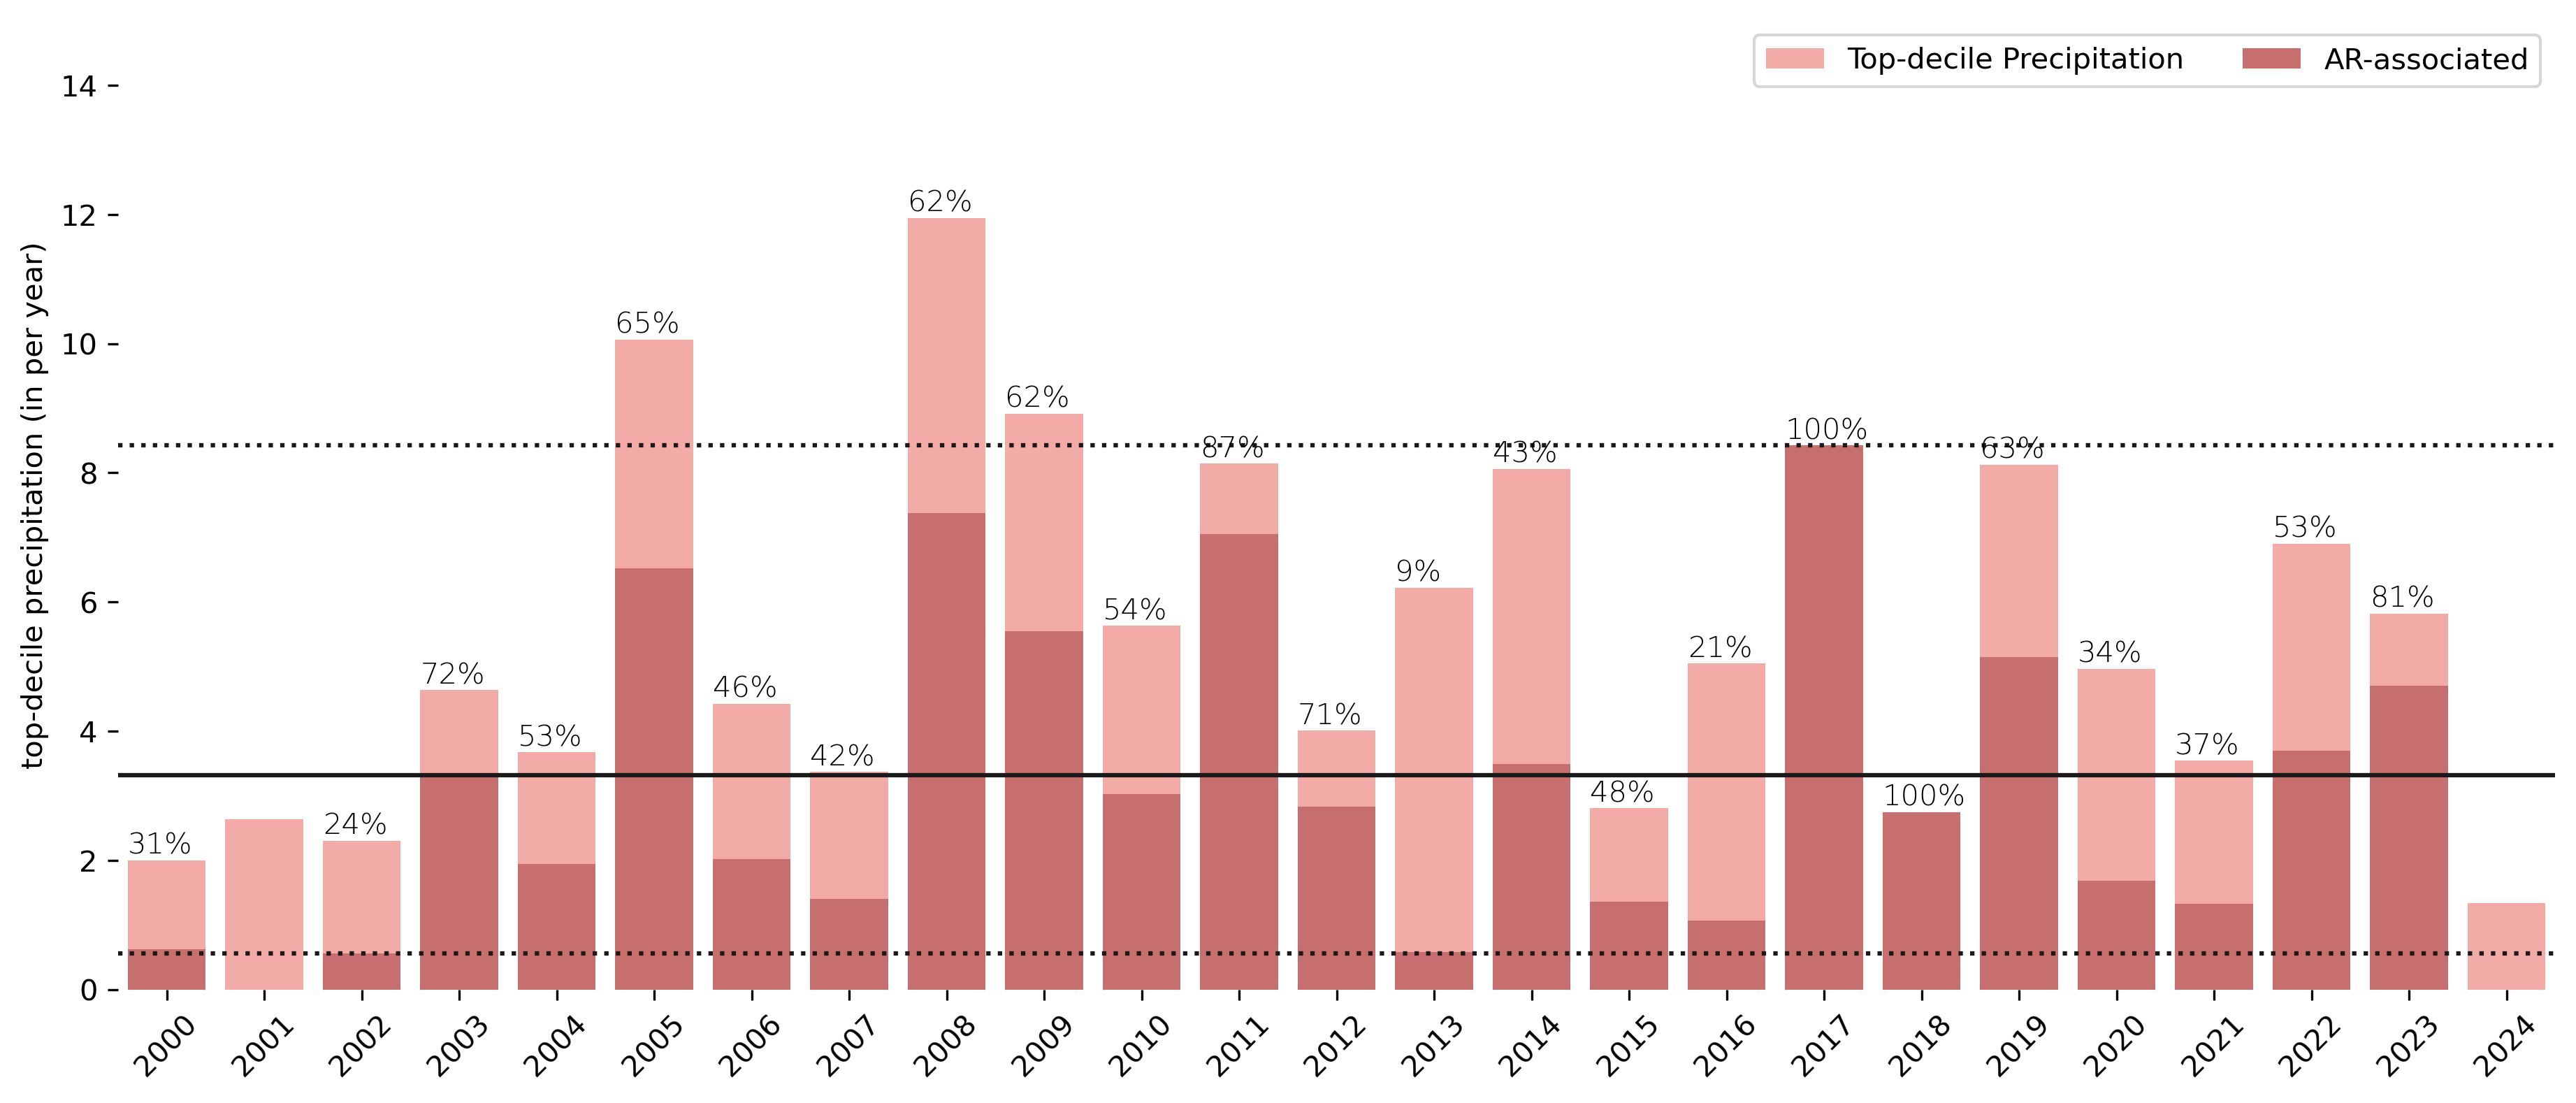

In [9]:
fig = plt.figure(figsize=(15,6))
fig.dpi = 300
fname = '../figs/time_series_extreme_{0}'.format(subbasin)
fmt1 = 'png'
gs = fig.add_gridspec(nrows=1, ncols=1)
color_list = ['b', 'r', 'g']


## Initialize the matplotlib figure
ax = fig.add_subplot(gs[0, 0])

# Plot the total precip
sns.set_color_codes("pastel")
d1 = sns.barplot(x=df2.index, y="Total Precipitation", data=df2, color='r', label="Top-decile Precipitation")

# Plot the precipitation where ARs were involved
sns.set_color_codes("muted")
d2 = sns.barplot(x=df2.index, y="AR Associated", data=df2, color='r', label="AR-associated")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="upper right", frameon=True)
ax.set(ylim=(0, 15), ylabel="top-decile precipitation (in per year)", xlabel="")
sns.despine(left=True, bottom=True)
#     ax.set_title(subtitles[i])
d1.set_xticklabels(d1.get_xticklabels(), rotation=45)

## add min/max/mean/median lines
ax.axhline(y=df2['AR Associated'].min(), color='k', linestyle=':')
ax.axhline(y=df2['AR Associated'].max(), color='k', linestyle=':') 
ax.axhline(y=df2['AR Associated'].mean(), color='k', linestyle='-')

yloc = df2['Total Precipitation'].values
xloc = np.arange(0, len(df2), 1)
proportion = df2['Percent'].values
for i, (x, prop) in enumerate(zip(xloc, proportion)):
    if prop > 0:
        plt.text(x=x-0.4,
                 y=yloc[i]+0.1,
                 s=f'{int(np.round(prop, 0))}%',
                 color="black",
                 fontsize=10,
                 fontweight="light", zorder=200)
    
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
plt.show()

In [ ]:
# AR = ds.where(ds[varname] > thres, drop=True).ar_scale
# da_groupby_monthly = AR.groupby('start_date.month').count(['start_date'])
# ## calculate monthly count (interannual time series)
# monthly_count = AR.resample(start_date='1MS').count(['start_date'])
# df = pd.DataFrame({'AR Count': monthly_count.values},
#                   index=monthly_count.start_date.values)

# df

In [ ]:
# fig = plt.figure(figsize=(10,3))
# fig.dpi = 300
# fname = '../figs/monthly_count_time_series_{0}'.format(subbasin)
# fmt1 = 'png'
# gs = fig.add_gridspec(nrows=1, ncols=1)
# color_list = ['b', 'r', 'g']

# ## create datetime labels for the x-axis
# date_lst = df.index.values
# xtck_lbl = []
# for i, x in enumerate(date_lst):
#     t = pd.to_datetime(str(x))
#     xtck_lbl.append(t.strftime('%Y-%m'))

# xtcks = np.arange(0, len(date_lst), 1)

# ## Initialize the matplotlib figure
# ax = fig.add_subplot(gs[0, 0])

# # Plot the precipitation where ARs were involved
# sns.set_color_codes("muted")
# d2 = sns.barplot(x=df.index, y="AR Count", data=df, color='b')

# # Add a legend and informative axis label
# ax.set(ylim=(0, 9), ylabel="ar frequency (#)", xlabel="")
# sns.despine(left=True, bottom=True)
# ax.set_xticks(xtcks[::12]) # set the labels every year
# ax.set_xticklabels(xtck_lbl[::12], fontsize=10)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
# fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
# plt.show()